In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Thu Jan 18 13:59:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
    p_samples2 = (torch.rand(hp.N, 1)*2-1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, -10, 10, temperature=1.0))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.25it/s]

-2.929292929292929


In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0636], device='cuda:0', grad_fn=<ExpBackward0>)


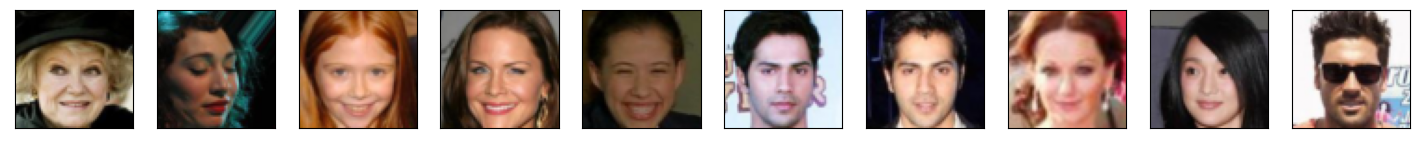

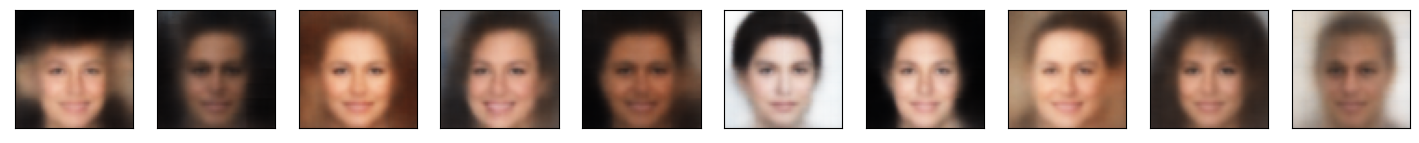

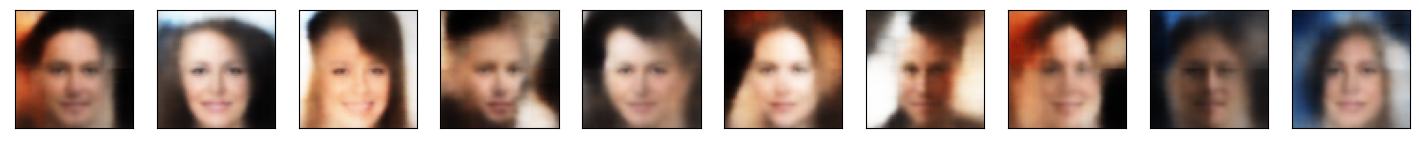

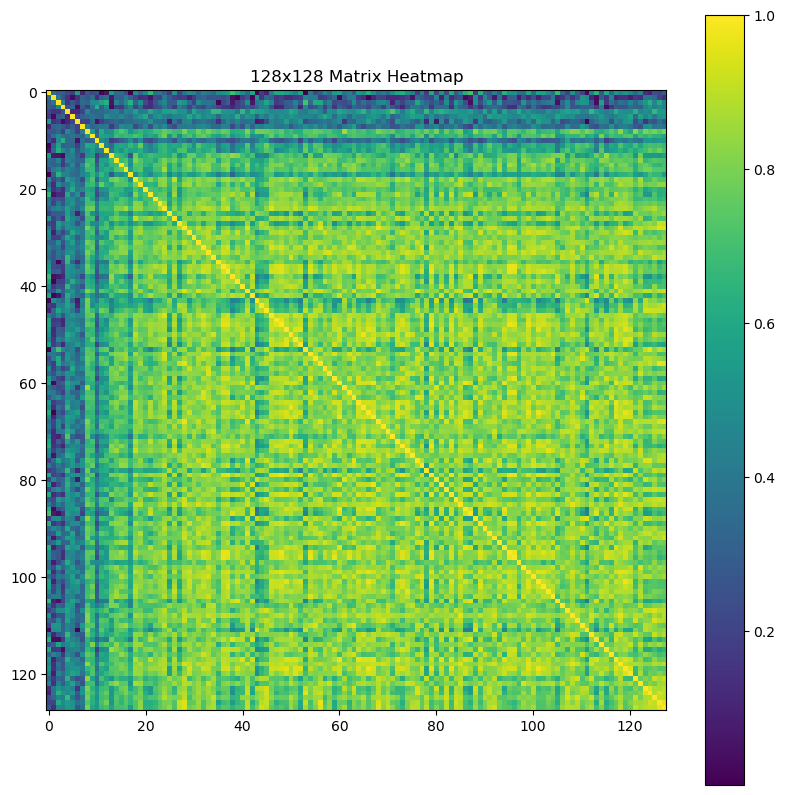

7001
lse_loss -0.6852774620056152
recon_loss 0.016220051795244217
7002
lse_loss -0.6880142688751221
recon_loss 0.016211293637752533
7003
lse_loss -0.683431088924408
recon_loss 0.01758369617164135
7004
lse_loss -0.6858295202255249
recon_loss 0.017003489658236504
7005
lse_loss -0.6833810806274414
recon_loss 0.017784161493182182
7006
lse_loss -0.6848165988922119
recon_loss 0.017706993967294693
7007
lse_loss -0.6882736682891846
recon_loss 0.016190718859434128
7008
lse_loss -0.684596598148346
recon_loss 0.017430506646633148
7009
lse_loss -0.6869677305221558
recon_loss 0.016611069440841675
7010
lse_loss -0.6874431371688843
recon_loss 0.01714935712516308
7011
lse_loss -0.6779914498329163
recon_loss 0.017356067895889282
7012
lse_loss -0.6860267519950867
recon_loss 0.015819191932678223
7013
lse_loss -0.6863532066345215
recon_loss 0.016503702849149704
7014
lse_loss -0.6855787634849548
recon_loss 0.01725873351097107
7015
lse_loss -0.6842069029808044
recon_loss 0.016955722123384476
7016
lse_loss -

7127
lse_loss -0.6836791038513184
recon_loss 0.016994625329971313
7128
lse_loss -0.6805095672607422
recon_loss 0.01596483215689659
7129
lse_loss -0.684424102306366
recon_loss 0.017060082405805588
7130
lse_loss -0.6873027086257935
recon_loss 0.016082262620329857
7131
lse_loss -0.6801934242248535
recon_loss 0.0165659561753273
7132
lse_loss -0.6844707727432251
recon_loss 0.01611938327550888
7133
lse_loss -0.6813138723373413
recon_loss 0.01568797044456005
7134
lse_loss -0.6718785762786865
recon_loss 0.017972050234675407
7135
lse_loss -0.6849130392074585
recon_loss 0.016695821657776833
7136
lse_loss -0.6844664216041565
recon_loss 0.01653233915567398
7137
lse_loss -0.685413122177124
recon_loss 0.017092779278755188
7138
lse_loss -0.6854106187820435
recon_loss 0.01598069816827774
7139
lse_loss -0.6862736940383911
recon_loss 0.017336521297693253
7140
lse_loss -0.6810332536697388
recon_loss 0.016836291179060936
7141
lse_loss -0.6877090930938721
recon_loss 0.017396213486790657
7142
lse_loss -0.68

7253
lse_loss -0.6875760555267334
recon_loss 0.01578049175441265
7254
lse_loss -0.681317925453186
recon_loss 0.016605980694293976
7255
lse_loss -0.6869888305664062
recon_loss 0.016463540494441986
7256
lse_loss -0.6811814308166504
recon_loss 0.017237678170204163
7257
lse_loss -0.6865466237068176
recon_loss 0.015821296721696854
7258
lse_loss -0.6806808114051819
recon_loss 0.016818715259432793
7259
lse_loss -0.6809631586074829
recon_loss 0.016428448259830475
7260
lse_loss -0.6874948740005493
recon_loss 0.0179903581738472
7261
lse_loss -0.6861860156059265
recon_loss 0.017095699906349182
7262
lse_loss -0.6856899857521057
recon_loss 0.014906182885169983
7263
lse_loss -0.6847895979881287
recon_loss 0.01791594736278057
7264
lse_loss -0.6869636178016663
recon_loss 0.016589507460594177
7265
lse_loss -0.6840092539787292
recon_loss 0.015974966809153557
7266
lse_loss -0.6810065507888794
recon_loss 0.015065962448716164
7267
lse_loss -0.6844912171363831
recon_loss 0.018034832552075386
7268
lse_loss -

7379
lse_loss -0.6851708889007568
recon_loss 0.01672513224184513
7380
lse_loss -0.6871699690818787
recon_loss 0.01523180678486824
7381
lse_loss -0.6831260919570923
recon_loss 0.015452593564987183
7382
lse_loss -0.6890299320220947
recon_loss 0.016103852540254593
7383
lse_loss -0.6860429048538208
recon_loss 0.01654762774705887
7384
lse_loss -0.6861662268638611
recon_loss 0.01638546958565712
7385
lse_loss -0.6859359741210938
recon_loss 0.016781311482191086
7386
lse_loss -0.6803296208381653
recon_loss 0.017184244468808174
7387
lse_loss -0.6829083561897278
recon_loss 0.01558380015194416
7388
lse_loss -0.6829334497451782
recon_loss 0.016709428280591965
7389
lse_loss -0.6854199171066284
recon_loss 0.017592772841453552
7390
lse_loss -0.6838559508323669
recon_loss 0.016341662034392357
7391
lse_loss -0.6841304302215576
recon_loss 0.017418865114450455
7392
lse_loss -0.685991644859314
recon_loss 0.016892574727535248
7393
lse_loss -0.6848445534706116
recon_loss 0.016658924520015717
7394
lse_loss -0

7504
lse_loss -0.6808137893676758
recon_loss 0.016338523477315903
7505
lse_loss -0.6853064298629761
recon_loss 0.0168556347489357
7506
lse_loss -0.6815098524093628
recon_loss 0.015951406210660934
7507
lse_loss -0.6863390207290649
recon_loss 0.015533353202044964
7508
lse_loss -0.6871967315673828
recon_loss 0.0157235786318779
7509
lse_loss -0.687789797782898
recon_loss 0.016153935343027115
7510
lse_loss -0.684822678565979
recon_loss 0.015983087942004204
7511
lse_loss -0.6858442425727844
recon_loss 0.015818094834685326
7512
lse_loss -0.6859660148620605
recon_loss 0.015700802206993103
7513
lse_loss -0.6861599087715149
recon_loss 0.015251907519996166
7514
lse_loss -0.6846054792404175
recon_loss 0.017108047381043434
7515
lse_loss -0.6829031705856323
recon_loss 0.015997929498553276
7516
lse_loss -0.6835449934005737
recon_loss 0.01580953598022461
7517
lse_loss -0.6867153644561768
recon_loss 0.01614375412464142
7518
lse_loss -0.6857837438583374
recon_loss 0.016699178144335747
7519
lse_loss -0.6

7630
lse_loss -0.6859681010246277
recon_loss 0.01705722138285637
7631
lse_loss -0.688034176826477
recon_loss 0.01699005626142025
7632
lse_loss -0.6848528385162354
recon_loss 0.016333159059286118
7633
lse_loss -0.6881636381149292
recon_loss 0.015703599900007248
7634
lse_loss -0.6858105063438416
recon_loss 0.015276841819286346
7635
lse_loss -0.6870511770248413
recon_loss 0.01725447177886963
7636
lse_loss -0.6879028081893921
recon_loss 0.016453275457024574
7637
lse_loss -0.6880875825881958
recon_loss 0.016006555408239365
7638
lse_loss -0.6880412101745605
recon_loss 0.017232617363333702
7639
lse_loss -0.6870927810668945
recon_loss 0.016790414229035378
7640
lse_loss -0.6839514970779419
recon_loss 0.016236579045653343
7641
lse_loss -0.6836017966270447
recon_loss 0.016284525394439697
7642
lse_loss -0.680884063243866
recon_loss 0.0169993843883276
7643
lse_loss -0.685268223285675
recon_loss 0.015702050179243088
7644
lse_loss -0.6832224130630493
recon_loss 0.01738668978214264
7645
lse_loss -0.68

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            corrcoef = torch.corrcoef(data['z_copy'].T).abs().data.cpu().numpy()
            # Plotting the matrix as a heatmap
            plt.figure(figsize=(10, 10))
            plt.imshow(corrcoef, cmap='viridis')
            plt.colorbar()
            plt.title('128x128 Matrix Heatmap')
            plt.show()
            
            corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
            writer.add_scalar('corrcoef', corrcoef, step)
        
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [12]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


In [27]:
np.mean(corrcoef * (1-np.eye(len(corrcoef))))

0.7264047475101449